# Example of cdr3-QTL analysis
- This is a vinuette that explains how we conductd cdr3-QTL analysis
- We provided several examples of input data in which we observed the strongest signals (HLA-DRB1 site 13 and L13-CDR3 position 109)

In [2]:
library(magrittr)
library(data.table)
library(plyr)
library(ggsci)
library(ggplot2)
library(ggrepel)
library(RColorBrewer)
library(ggseqlogo)

## Read in data
- In DRB1_site13_L13CDR3_p109.RData, you can find three critical data for cdr3-QTL analysis
- 1, amino acid frequencies at position 109 of CDR3 (L=13): we calculated the frequency of each amino acid using the data downloaded from Adaptive Biotechnology.
- 2, genotype of DRB1_pos13: we calculated allele count of each allele using the data downloaded from Adaptive Biotechnology.
- 3, covariates of PC1-3 of genotype. 
- we deposited separate scripts showing how we generated these data.

In [3]:
load("DRB1_site13_L13CDR3_p109.RData")
pdata <- out[[1]] #CDR3 phenotype
gdata <- out[[2]] #genotype at HLA-DRB1
cdata <- out[[3]] #covariates

### CDR3 phenotype

In [5]:
#this is the input data of CDR3 amino acid frequencies
#sample name, amino acid ID, and frequencies
head(pdata)

Sample,AA,rate
HIP00110,A,0.066906200
HIP00110,C,0.000359324
HIP00110,D,0.084872400
HIP00110,E,0.036723000
HIP00110,F,0.009558030
HIP00110,G,0.274021000


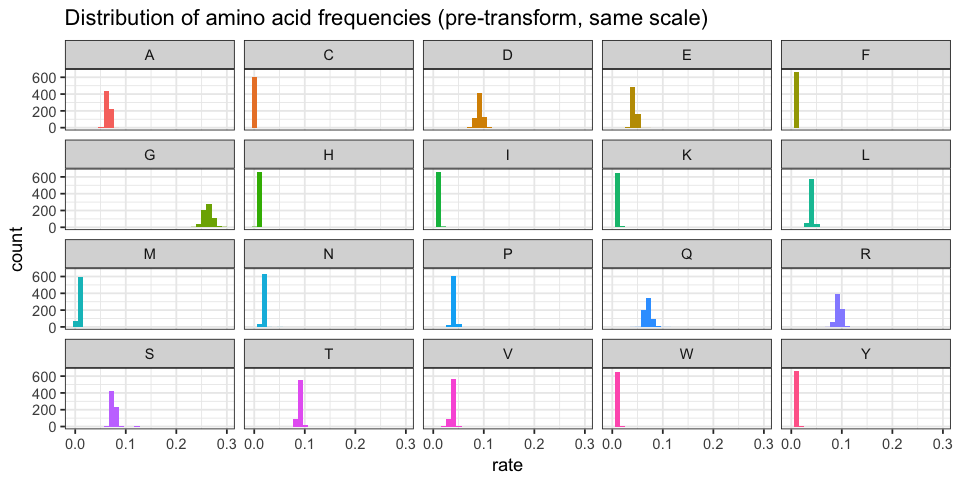

In [6]:
#here, we showed the distributions of CDR3 amino acid frequencies
#with a fixed scale on the X axis
df <- pdata

options(repr.plot.width=8, repr.plot.height=4)
df %>% ggplot(aes(x=rate,fill=AA))+
    geom_histogram(bins = 30)+
    facet_wrap(~AA)+
    theme_bw()+
    theme(legend.position = "none")+
    labs(title="Distribution of amino acid frequencies (pre-transform, same scale)")

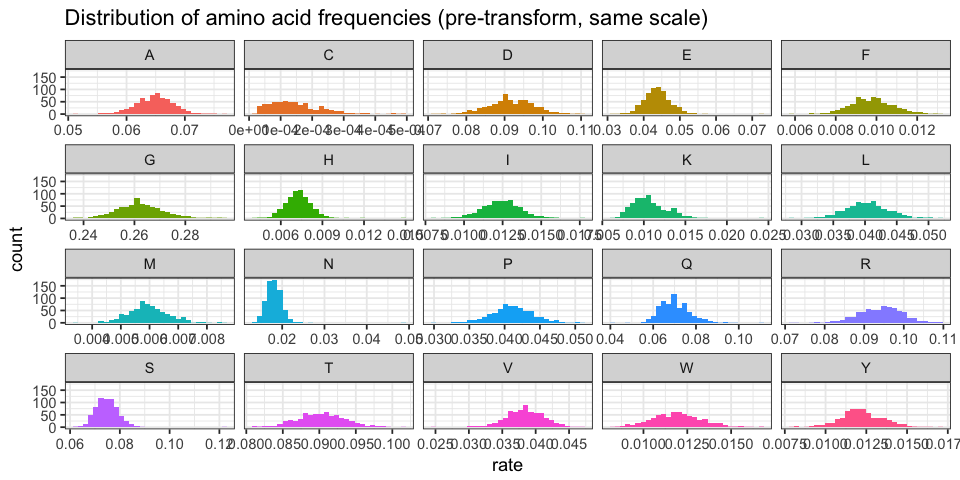

In [8]:
#next, we showed distributions of CDR3 amino acid frequencies
#with a FREE scale on the X axis
df %>% ggplot(aes(x=rate,fill=AA))+
    geom_histogram(bins = 30)+
    facet_wrap(~AA,scale="free_x")+
    theme_bw()+
    theme(legend.position = "none")+
    labs(title="Distribution of amino acid frequencies (pre-transform, same scale)")

In [10]:
#we transformed each amino acid frequency into a standard normal distribution (INT-transform).
#we used this transformed data as in many other eQTL studies.
pall <- data.frame()
pnamelist <- unique(pdata$AA)
for( ptarget in pnamelist ){
    pdata2 <- subset(pdata, AA==ptarget)
    pdata2 <- pdata2[,c("Sample", "rate")]
    x <- pdata2$rate
    pdata2$normrate <- qnorm( (rank(x, na.last="keep") - 0.5) / sum(!is.na(x)) ) #inverse normal normalization
    
    df <- pdata2[,c("Sample","normrate")]
    df$AA <- ptarget
    pall <- rbind(pall,df)
}
head(pall)

,Sample,normrate,AA
1,HIP00110,0.679222336,A
21,HIP00169,-0.069684920,A
41,HIP00734,-0.543062041,A
60,HIP02805,-0.005645589,A
80,HIP02811,0.198898245,A
100,HIP02820,0.175915459,A


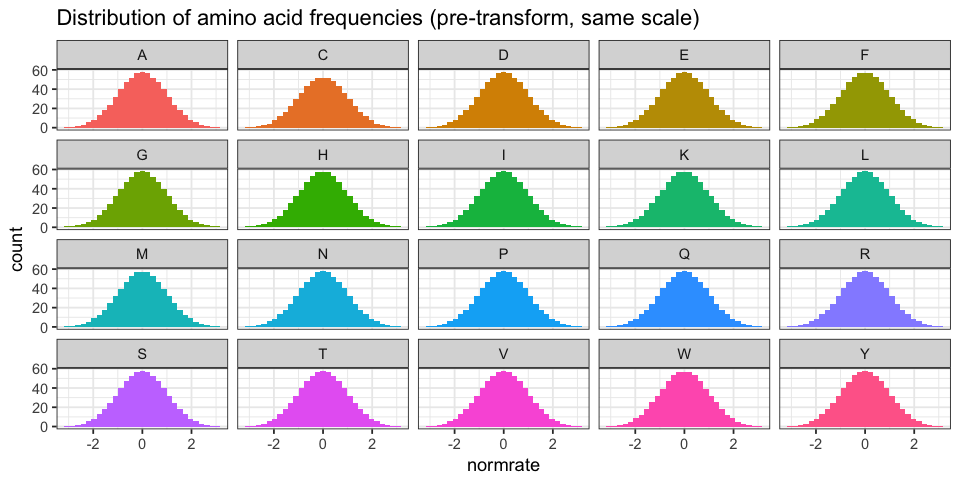

In [11]:
#finally, we showed the distributions of CDR3 amino acid frequencies of post-transformation.
#as you can see, the data is normally distributted.
options(repr.plot.width=8, repr.plot.height=4)
df <- pall
df %>% ggplot(aes(x=normrate,fill=AA))+
    geom_histogram(bins = 30)+
    facet_wrap(~AA)+
    theme_bw()+
    theme(legend.position = "none")+
    labs(title="Distribution of amino acid frequencies (pre-transform, same scale)")

In [12]:
#transform pall into a matrix
mat <- matrix(0, nrow=length(unique(pall$Sample)), ncol=length(unique(pall$AA)) )
row.names(mat) <- unique(pall$Sample)
colnames(mat) <- unique(pall$AA)

for( i in unique(pall$Sample) ){
for( k in unique(pall$AA) ){
   out <- subset(pall, Sample==i & AA==k)
   if( nrow(out) ==1 ){
      mat[i,k] <- out$normrate
   }else{
       mat[i,k] <- 0
   }
}
}
mat <- data.frame(Sample=row.names(mat),mat)
head(mat)

,Sample,A,C,D,E,F,G,H,I,K,⋯,M,N,P,Q,R,S,T,V,W,Y
HIP00110,HIP00110,0.679222336,1.9515905,-1.14127920,-1.9385796,-0.14753879,1.3085386,-1.3076930,-1.078567041,1.1403624,⋯,0.22039452,-0.9175417,-0.2374441,-1.15583721,1.51161973,0.07723269,-0.02446653,1.2407051,1.6268950,0.29595131
HIP00169,HIP00169,-0.069684920,-0.6822739,0.27634606,-2.0798691,1.54724362,-1.2010554,1.7524338,3.174393173,1.2237339,⋯,1.47635124,1.2166860,-1.3732660,-0.86710244,0.95844614,-0.27634606,0.13781024,3.1743932,-1.2645992,-1.45508531
HIP00734,HIP00734,-0.543062041,0.0000000,0.08100819,-0.4286634,-0.04147491,-0.7127896,-0.3221112,0.233574514,-0.8335914,⋯,-1.65588870,-0.6839702,-0.6935125,0.57385479,0.18356547,1.12695913,-0.23744406,-0.3117175,-0.5815019,2.04819863
HIP02805,HIP02805,-0.005645589,0.5286627,-0.19506081,0.1701847,0.22812525,-0.9886737,0.7813674,0.001881854,1.0642443,⋯,0.38633562,-0.1378102,-0.1720943,0.05083191,0.25684647,0.15302523,0.98255637,0.5782978,0.3500305,0.13781024
HIP02811,HIP02811,0.198898245,-0.9795615,0.30776881,0.3196294,-0.72137847,-0.2181306,0.4272834,-0.609727942,-0.2319957,⋯,0.54615062,0.6983074,-0.3315352,0.98255637,-0.44107437,-0.29202139,-0.59618589,-0.3394985,-0.3380330,0.58275230
HIP02820,HIP02820,0.175915459,0.8247043,-0.19122624,0.8616341,0.33006165,-0.9584461,0.1323129,0.323592923,-0.1589805,⋯,-0.01884795,-1.0325772,1.5605981,-1.07185807,0.05083191,1.42328120,-0.23357451,0.2685340,0.3822774,-0.03576283


### HLA-DRB1 site 13 allele count

In [13]:
#this is an input data of HLA amino acid allele count
colnames(gdata) <- c('Sample',
                     'F_allele','G_allele','H_allele','R_allele','S_allele','Y_allele')
head(gdata)

,Sample,F_allele,G_allele,H_allele,R_allele,S_allele,Y_allele
HIP00110,HIP00110,0,0,0,2,0,0
HIP00169,HIP00169,0,0,0,2,0,0
HIP00594,HIP00594,0,0,0,1,1,0
HIP00602,HIP00602,0,0,1,0,1,0
HIP00614,HIP00614,1,0,0,1,0,0
HIP00640,HIP00640,0,0,1,0,0,1


In [14]:
rowSums(gdata[,-1]) %>% table() #all, sum = 2 (because each individual has two alleles)

#allele frequency
gdata[,-1] %>% colSums()/nrow(gdata)/2
    #S_allele is the most frequent allele

.
  2 
630 

F_allele   G_allele   H_allele   R_allele   S_allele   Y_allele 
0.13968254 0.05634921 0.16031746 0.15555556 0.36269841 0.12539683

### covariate (genotype PCA)

In [15]:
#this is an input data of covariates
head(cdata)

,Sample,PC1,PC2,PC3
HIP00110,HIP00110,-0.3715639,0.1614687,0.9765430
HIP00169,HIP00169,-0.8574693,1.4323182,-0.9377073
HIP00594,HIP00594,0.3055545,0.6570370,-1.2958039
HIP00602,HIP00602,0.8394371,-1.1396599,-3.4511489
HIP00614,HIP00614,-1.3516954,-0.9016350,1.9387326
HIP00640,HIP00640,0.5917640,2.0007343,-1.5166001


## Multivariate linear regression model (MLM)

### Estimate P value using R function anova.mlm
- This is the way I calculate P value in my manuscript (Pillai statistics in MANOVA)

In [17]:
M <- merge(gdata,mat,by="Sample")
M <- merge(M,cdata,by="Sample")
head(M)

Sample,F_allele,G_allele,H_allele,R_allele,S_allele,Y_allele,A,C,D,⋯,Q,R,S,T,V,W,Y,PC1,PC2,PC3
HIP00110,0,0,0,2,0,0,0.67922234,1.9515905,-1.1412792,⋯,-1.15583721,1.51161973,0.07723269,-0.02446653,1.24070509,1.6268950,0.2959513,-0.3715639,0.1614687,0.9765430
HIP00169,0,0,0,2,0,0,-0.06968492,-0.6822739,0.2763461,⋯,-0.86710244,0.95844614,-0.27634606,0.13781024,3.17439317,-1.2645992,-1.4550853,-0.8574693,1.4323182,-0.9377073
HIP00594,0,0,0,1,1,0,0.37157379,1.4406943,-1.1059024,⋯,0.04706369,0.56500249,0.05083191,0.23744406,-0.04329614,0.4731723,0.1835655,0.3055545,0.6570370,-1.2958039
HIP00602,0,0,1,0,1,0,0.54306204,-1.5143614,0.2258458,⋯,0.21813064,0.04329614,-0.17591546,-0.40403608,-0.74717993,-1.5348852,-0.9407230,0.8394371,-1.1396599,-3.4511489
HIP00614,1,0,0,1,0,0,2.84048462,1.0556713,-2.6734518,⋯,-2.84048462,2.04819863,2.84048462,-2.46994154,1.09899150,0.7510350,-0.8616341,-1.3516954,-0.9016350,1.9387326
HIP00640,0,0,1,0,0,1,-0.90613413,-0.8074489,1.4443212,⋯,1.26546216,-1.08532491,-0.47030358,0.15302523,0.51707314,0.9754778,1.3355950,0.5917640,2.0007343,-1.5166001


In [18]:
#full model (exclude S_allele, the most frequent allele, as the reference allele)
mod1 <- lm( 
    cbind(A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y) ~
        F_allele + G_allele + H_allele + R_allele + Y_allele +
        PC1+PC2+PC3, 
    data = M)

#null model
mod0 <- lm( 
    cbind(A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y) ~
        PC1+PC2+PC3, 
    data = M)

In [19]:
test <- anova(mod1, mod0)
test
    #P manova = 2.660403e-138

Res.Df,Df,Gen.var.,Pillai,approx F,num Df,den Df,Pr(>F)
619,NA,0.5945617,NA,NA,NA,NA,NA
624,5,0.6416781,1.329817,10.94236,100,3020,2.660403e-138


### Estimate P value using custom script
- Successfully reproduced the same statistics using a custom script
- References:
- https://online.stat.psu.edu/stat505/lesson/8
- https://support.sas.com/documentation/cdl/en/statug/63033/

In [21]:
#full model (exclude S_allele, the most frequent allele, as the reference allele)
mod1 <- lm( 
    cbind(A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y) ~
        F_allele + G_allele + H_allele + R_allele + Y_allele +
        PC1+PC2+PC3, 
    data = M)

#null model
mod0 <- lm( 
    cbind(A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y) ~
        PC1+PC2+PC3, 
    data = M)

In [22]:
#response variable matrix
Y <- M[,c("A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","Y")]
Y <- as.matrix(Y)
dim(Y)
Y[1:5,1:5]

[1] 628  20

A,C,D,E,F
0.67922234,1.9515905,-1.1412792,-1.9385796,-0.1475388
-0.06968492,-0.6822739,0.2763461,-2.0798691,1.5472436
0.37157379,1.4406943,-1.1059024,-0.5474289,0.6313380
0.54306204,-1.5143614,0.2258458,-0.1530252,-0.1323129
2.84048462,1.0556713,-2.6734518,-1.1781452,-1.0062700


In [23]:
#degree of freedom of full and null model
DF_full <- mod1$df.residual
DF_null <- mod0$df.residual

DF_full
DF_null

[1] 619

[1] 624

In [24]:
#matrix of residuals
Res_full <- Y - mod1$fitted.values
dim(Res_full)

[1] 628  20

In [25]:
Res_null <- Y - mod0$fitted.values
dim(Res_null)

[1] 628  20

In [26]:
Emat <- crossprod(Res_full)
Hmat <- crossprod(Res_null) - crossprod(Res_full)
dim(Emat)
dim(Hmat)

[1] 20 20

[1] 20 20

In [27]:
Pillai <- sum(diag( Hmat %*% solve( Hmat + Emat ) ))
Pillai

[1] 1.329817

In [28]:
p=20 #DF of Y matrix (N of amino acids)
q=5 #DF of X (dose1-dose5)
s=min(p,q)
v=DF_full
m=(abs(p-q)-1)/2
n=(v-p-1)/2
appF <- (2*n + s + 1)/(2*m + s + 1) * ( Pillai / (s - Pillai) )
appF #the identical value as R function (see above)

[1] 10.94236

In [29]:
numDF <- s*(2*n + s + 1)
numDF #the identical value as R function (see above)

[1] 3020

In [30]:
dnomDF <- s*(2*m + s + 1)
dnomDF #the identical value as R function (see above)

[1] 100

In [31]:
#obtained the same P value!!
pf(appF, dnomDF,numDF, lower.tail = FALSE) #the identical value as R function (see above)

[1] 2.660403e-138

### Variance explained using R function MVLM
- This is the way I calculate the variance explained in my manuscript

In [32]:
library(MVLM)

#full model
mod1 <- mvlm( 
    cbind(A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y) ~
        F_allele + G_allele + H_allele + R_allele + Y_allele +
        PC1+PC2+PC3, 
    data = M)

var_exp_full <- mod1$pseudo.rsq["Omnibus Effect",1]
show(var_exp_full)

Omnibus Effect 
     0.1312758 


In [33]:
#null model
mod0 <- mvlm( 
    cbind(A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y) ~
        PC1+PC2+PC3, 
    data = M)

var_exp_null <- mod0$pseudo.rsq["Omnibus Effect",1]
show(var_exp_null)

Omnibus Effect 
    0.03785477 


In [34]:
var_exp_full - var_exp_null
    #this is the variance explained in the main analysis

Omnibus Effect 
    0.09342102

### Variance explained using the custom script (matrix multiplication)
- Successfully reproduced the same statistics using a custom script

In [35]:
Y <- M[,c("A","C","D","E","F","G","H","I","K", "L","M","N","P","Q","R","S","T","V","W","Y")]
Y <-as.matrix(Y)
dim(Y)
Y[1:4,1:4]

[1] 628  20

A,C,D,E
0.67922234,1.9515905,-1.1412792,-1.9385796
-0.06968492,-0.6822739,0.2763461,-2.0798691
0.37157379,1.4406943,-1.1059024,-0.5474289
0.54306204,-1.5143614,0.2258458,-0.1530252


In [36]:
#full model
X <- M[,c("F_allele","G_allele","H_allele","R_allele","Y_allele","PC1","PC2","PC3")]
X$Intercept <- 1
X <-as.matrix(X)
dim(X)
X[1:4,]

[1] 628   9

F_allele,G_allele,H_allele,R_allele,Y_allele,PC1,PC2,PC3,Intercept
0,0,0,2,0,-0.3715639,0.1614687,0.9765430,1
0,0,0,2,0,-0.8574693,1.4323182,-0.9377073,1
0,0,0,1,0,0.3055545,0.6570370,-1.2958039,1
0,0,1,0,0,0.8394371,-1.1396599,-3.4511489,1


In [37]:
n <-nrow(X)
p <-ncol(X)
q <-ncol(Y)
H <-tcrossprod(tcrossprod(X,solve(crossprod(X))), X)
 # hat matrix
  # X %*% ( t(X) %*% X )^-1 %*% t(X)

mean.Y <-matrix(apply(Y, 2, mean), nrow = n, ncol = q, byrow = T)
sscp.mean.Y <-crossprod(mean.Y)
sscp.Y <-crossprod(Y)
sscp <- sscp.Y - sscp.mean.Y
sscp.r <- (crossprod(Y, H)%*%Y) - sscp.mean.Y

var_exp_full <-sum(diag(sscp.r))/sum(diag(sscp)) 
var_exp_full # the identical value as above

[1] 0.1312758

In [38]:
#null model
X <- M[,c("PC1","PC2","PC3")]
X$Intercept <- 1
X <-as.matrix(X)
dim(X)
X[1:4,]

[1] 628   4

PC1,PC2,PC3,Intercept
-0.3715639,0.1614687,0.9765430,1
-0.8574693,1.4323182,-0.9377073,1
0.3055545,0.6570370,-1.2958039,1
0.8394371,-1.1396599,-3.4511489,1


In [39]:
n <-nrow(X)
p <-ncol(X)
q <-ncol(Y)
H <-tcrossprod(tcrossprod(X,solve(crossprod(X))), X)
 # hat matrix
  # X %*% ( t(X) %*% X )^-1 %*% t(X)

mean.Y <-matrix(apply(Y, 2, mean), nrow = n, ncol = q, byrow = T)
sscp.mean.Y <-crossprod(mean.Y)
sscp.Y <-crossprod(Y)
sscp <- sscp.Y - sscp.mean.Y
sscp.r <- (crossprod(Y, H)%*%Y) - sscp.mean.Y

var_exp_null <-sum(diag(sscp.r))/sum(diag(sscp)) 
var_exp_null # the identical value as above

[1] 0.03785477

In [40]:
var_exp_full - var_exp_null
    #explained variance, the same value as above results with MVLM package

[1] 0.09342102

## linear regression model (LM)
- an example of LM analysis between HLA-DRB1 R_allele and L13-CDR3 amino acid K

In [64]:
#prepare phenotype data
pdata2 <- subset(pdata, AA=="K")
pdata2 <- pdata2[,c("Sample", "rate")]
head(pdata2)

,Sample,rate
9,HIP00110,0.01336690
29,HIP00169,0.01349980
48,HIP00734,0.00895351
68,HIP02805,0.01323210
88,HIP02811,0.01001790
108,HIP02820,0.01015070


In [65]:
#prepare genotyep data
gdata2 <- gdata[,c("Sample","R_allele")]
head(gdata2)

,Sample,R_allele
HIP00110,HIP00110,2
HIP00169,HIP00169,2
HIP00594,HIP00594,1
HIP00602,HIP00602,0
HIP00614,HIP00614,1
HIP00640,HIP00640,0


In [66]:
M <- merge(pdata2,gdata2,by="Sample")
M <- merge(M,cdata,by="Sample")

#inverse normal normalization
x <- M$rate
M$normrate <- qnorm( (rank(x, na.last="keep") - 0.5) / sum(!is.na(x)) ) 

head(M)

Sample,rate,R_allele,PC1,PC2,PC3,normrate
HIP00110,0.01336690,2,-0.3715639,0.1614687,0.9765430,1.1416765
HIP00169,0.01349980,2,-0.8574693,1.4323182,-0.9377073,1.2220451
HIP00594,0.01329150,1,0.3055545,0.6570370,-1.2958039,1.0895372
HIP00602,0.01008120,0,0.8394371,-1.1396599,-3.4511489,-0.1849484
HIP00614,0.01412200,1,-1.3516954,-0.9016350,1.9387326,1.5838070
HIP00640,0.00814656,0,0.5917640,2.0007343,-1.5166001,-1.3599565


In [67]:
mod1 <- lm( 
    normrate ~ R_allele + PC1+PC2+PC3, 
    data = M)

In [69]:
summary(mod1)$coefficient["R_allele",,drop=F]

,Estimate,Std. Error,t value,Pr(>|t|)
R_allele,1.026193,0.06711885,15.2892,4.923181e-45


## Visualization
- plot CDR3 amino acid frequencies vs HLA allele count
- you can see a strong influences of HLA alleles on CDR3 amino acid frequencies (e.g. K)

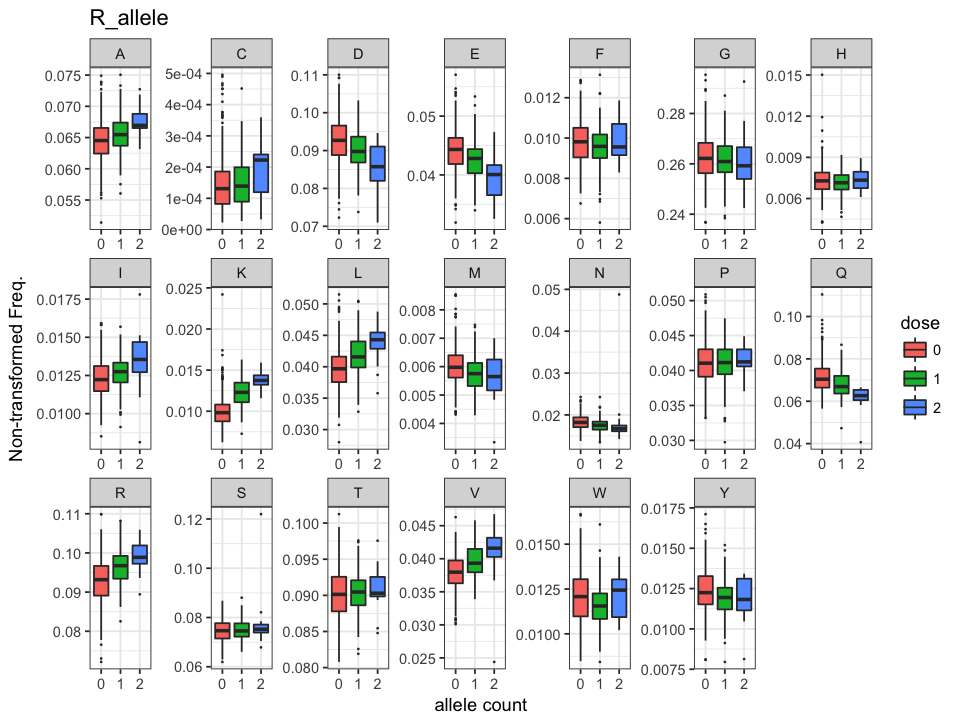

In [76]:
#non-transformed frequency
options(repr.plot.width=8, repr.plot.height=6)

allele <- "R_allele"

d1 <- pdata
d2 <- gdata[,c("Sample",allele)]
df <- merge(d1,d2,by="Sample")
colnames(df)[4] <- "dose"
df$dose <- as.character(df$dose)

df %>% ggplot(aes(x=dose,y=rate,fill=dose)) +
    facet_wrap(~AA,ncol=7,scale="free")+ #
    labs(y="Non-transformed Freq.")+
    geom_boxplot(outlier.size = 0.1) +
    theme(legend.position = "none") +
    theme_bw() +
    labs(title=allele,x="allele count") -> p

plot(p)
